# Task 1.1 - Dataset Exploration

### Load training data in a dataframe

In [1]:
import gdown
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from utils import TimeSeriesDataset, collate_fn, load_data

In [2]:
data_url = "https://drive.google.com/drive/folders/1MyX__3hRiPkWHGFKqZXpOyq32KQpPDTR?usp=sharing"
gdown.download_folder(data_url, quiet=False)

Retrieving folder contents


Processing file 1k4zVB77UNftw5BgCX0kr2FlWC0TV9Gz1 X_test.bin
Processing file 1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v X_train.bin
Processing file 139Kj5xAmTuy2YBzygzNqIzBFScaWywEC y_train.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1k4zVB77UNftw5BgCX0kr2FlWC0TV9Gz1
To: c:\Users\zainm\Desktop\AMLS\data\X_test.bin
100%|██████████| 51.5M/51.5M [00:01<00:00, 27.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v
From (redirected): https://drive.google.com/uc?id=1T_-zQOkEPpMpYTV1OeDepsKwr8TASS_v&confirm=t&uuid=ab347fba-9f55-4e96-bb2c-59569b25c8e4
To: c:\Users\zainm\Desktop\AMLS\data\X_train.bin
100%|██████████| 121M/121M [00:04<00:00, 28.8MB/s] 
Downloading...
From: https://drive.google.com/uc?id=139Kj5xAmTuy2YBzygzNqIzBFScaWywEC
To: c:\Users\zainm\Desktop\AMLS\data\y_train.csv
100%|██████████| 12.4k/12.4k [00:00<00:00, 6.10MB/s]
Download completed


['c:\\Users\\zainm\\Desktop\\AMLS\\data\\X_test.bin',
 'c:\\Users\\zainm\\Desktop\\AMLS\\data\\X_train.bin',
 'c:\\Users\\zainm\\Desktop\\AMLS\\data\\y_train.csv']

In [3]:
ecg_data_path = 'data/X_train.bin'
labels_path = 'data/y_train.csv'

ecg_data = load_data(ecg_data_path, 'rb')
labels = load_data(labels_path, 'r')

In [4]:
df = pd.DataFrame({'Data': ecg_data, 'Class': labels})
df['Lengths'] = df['Data'].apply(lambda seq: len(seq))
print(f'Number of total data points: {df["Data"].count()}')
df.head()

Number of total data points: 6179


,Data,Class,Lengths
0,"[-217, -246, -294, -344, -363, -371, -377, -37...",2,9000
1,"[-446, -541, -637, -733, -819, -858, -867, -87...",2,18000
2,"[-440, -527, -614, -698, -770, -790, -796, -79...",2,9000
3,"[-1255, -1488, -1745, -2015, -2253, -2374, -23...",0,9000
4,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ...",0,9000


## Plot some samples

In [5]:
# normalize data points
sequences = df["Data"].to_numpy()
concat = np.concatenate(sequences).reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(concat)
normalized_data = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in sequences]


def plot_sequences(data, labels, num_rows, num_cols, start_idx=0, total_sequences=10, xlim_right=1200, title="Plots"):
  
  assert 0 <= start_idx < len(data)
  assert 0 < total_sequences and total_sequences == num_rows * num_cols
  # assert start_idx + total_sequences < len(data)

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 + num_rows))
  sequences = data[start_idx : start_idx + total_sequences]
  classes = labels[start_idx : start_idx + total_sequences]
  sorted_idcs = np.argsort(classes)

  offset = 0
  for i in range(num_rows):
    for j in range(num_cols):
      seq = sequences[sorted_idcs[offset]]
      clss = classes[sorted_idcs[offset]]
      axs[i, j].plot(seq, label=clss)
      axs[i, j].set_xlim(0, xlim_right)
      axs[i, j].legend()
      offset += 1
  
  fig.suptitle(title, fontsize=16, y=0.95)
  plt.show()

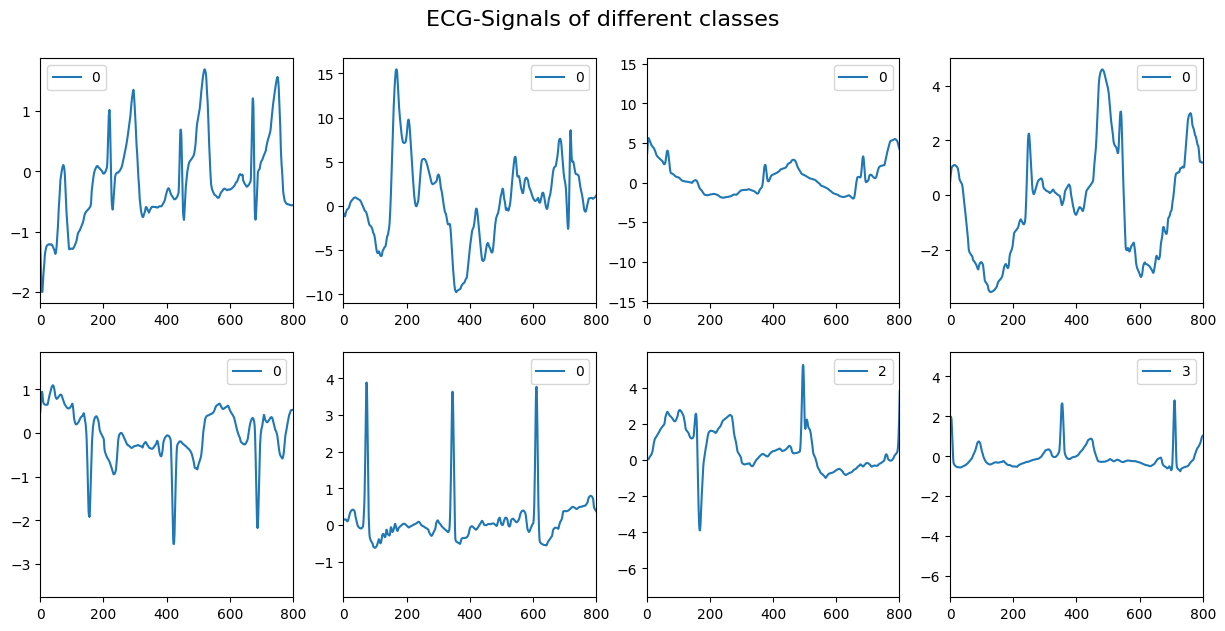

In [6]:
plot_sequences(
    normalized_data, 
    df["Class"].to_numpy(), 
    num_rows=2, num_cols=4, 
    start_idx=90, total_sequences=8, 
    xlim_right=800, title="ECG-Signals of different classes"
)

## Plot class distribution

Class 0: 3638	Class 1: 549	Class 2: 1765	Class 3: 227


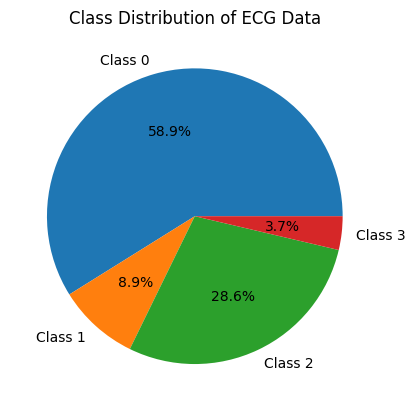

In [7]:
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

_df = df.groupby('Class').count()
count = _df['Data'].to_numpy()
print(f"Class 0: {count[0]}\tClass 1: {count[1]}\tClass 2: {count[2]}\tClass 3: {count[3]}")

fig, ax = plt.subplots()
ax.pie(count, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of ECG Data')
plt.show()

## Analyze the lengths of the samples

- This information is relevant for model-selection and pre-processing of data for model


In [8]:
unique_lengths, counts = np.unique(df['Lengths'], return_counts=True)
min_val = unique_lengths.min()
max_val = unique_lengths.max()
mean_val = unique_lengths.mean()
most_frequent_length = unique_lengths[np.argmax(counts)]

# print(np.max(counts), counts[np.argmax(counts)])

print(f'Number of all different lengths: {len(unique_lengths)}\n')
print("--- Absolute Lengths ---")
print(f'Min Length: {min_val}')
print(f'Max Length: {max_val}')
print(f'Avg. Length: {mean_val:.2f}')
print(f'Most Frequent Length: {most_frequent_length} with total of {np.max(counts)} occurences\n')

print("--- Class dependant Lengths ---")
mins = df.groupby("Class")["Lengths"].min()
maxs = df.groupby("Class")["Lengths"].max()
avgs = df.groupby("Class")["Lengths"].mean()
print(f"Class 0  --  Min-Length: {mins[0]}  -  Max-Length: {maxs[0]}  -  Avg-Length: {int(avgs[0])}")
print(f"Class 1  --  Min-Length: {mins[1]}  -  Max-Length: {maxs[1]}  -  Avg-Length: {int(avgs[1])}")
print(f"Class 2  --  Min-Length: {mins[2]}  -  Max-Length: {maxs[2]}  -  Avg-Length: {int(avgs[2])}")
print(f"Class 3  --  Min-Length: {mins[3]}  -  Max-Length: {maxs[3]}  -  Avg-Length: {int(avgs[3])}")

Number of all different lengths: 1082

--- Absolute Lengths ---
Min Length: 2714
Max Length: 18286
Avg. Length: 8638.57
Most Frequent Length: 9000 with total of 4341 occurences

--- Class dependant Lengths ---
Class 0  --  Min-Length: 2714  -  Max-Length: 18286  -  Avg-Length: 9662
Class 1  --  Min-Length: 2996  -  Max-Length: 18062  -  Avg-Length: 9510
Class 2  --  Min-Length: 2738  -  Max-Length: 18188  -  Avg-Length: 10366
Class 3  --  Min-Length: 2808  -  Max-Length: 18000  -  Avg-Length: 7210


## Compute descriptive statistics

In [9]:
def get_class_statistics(df: pd.DataFrame, class_: int):

    group = df.groupby("Class")["Data"].get_group(class_)
    all_stats = np.zeros(8)

    for series in group:
        stats = pd.Series(series).describe()
        all_stats += stats

    all_stats /= group.shape[0]
    return all_stats

# df.groupby("Class")["Data"].apply()
count0, mean0, std0, min0, quant0_25, quant0_50, quant0_75, max0 = get_class_statistics(df, 0)
count1, mean1, std1, min1, quant1_25, quant1_50, quant1_75, max1 = get_class_statistics(df, 1)
count2, mean2, std2, min2, quant2_25, quant2_50, quant2_75, max2 = get_class_statistics(df, 2)
count3, mean3, std3, min3, quant3_25, quant3_50, quant3_75, max3 = get_class_statistics(df, 3)

In [10]:
print(f"-- Class 0 -- \n\nCount: {int(count0)}\nMean: {mean0:.2f}\nMin: {min0:.2f}\nMax: {max0:.2f}\n25% Quantile: {quant0_25:.2f}\n50% Quantile: {quant0_50:.2f}\n75% Quantile: {quant0_75:.2f}\n")
print(f"-- Class 1 -- \n\nCount: {int(count1)}\nMean: {mean1:.2f}\nMin: {min1:.2f}\nMax: {max1:.2f}\n25% Quantile: {quant1_25:.2f}\n50% Quantile: {quant1_50:.2f}\n75% Quantile: {quant1_75:.2f}\n")
print(f"-- Class 2 -- \n\nCount: {int(count2)}\nMean: {mean2:.2f}\nMin: {min2:.2f}\nMax: {max2:.2f}\n25% Quantile: {quant2_25:.2f}\n50% Quantile: {quant2_50:.2f}\n75% Quantile: {quant2_75:.2f}\n")
print(f"-- Class 3 -- \n\nCount: {int(count3)}\nMean: {mean3:.2f}\nMin: {min3:.2f}\nMax: {max3:.2f}\n25% Quantile: {quant3_25:.2f}\n50% Quantile: {quant3_50:.2f}\n75% Quantile: {quant3_75:.2f}")

-- Class 0 -- 

Count: 9662
Mean: 7.58
Min: -1069.66
Max: 1289.28
25% Quantile: -69.80
50% Quantile: -9.94
75% Quantile: 64.01

-- Class 1 -- 

Count: 9510
Mean: 8.91
Min: -913.85
Max: 1098.64
25% Quantile: -63.69
50% Quantile: -7.07
75% Quantile: 58.88

-- Class 2 -- 

Count: 10366
Mean: 6.90
Min: -1042.66
Max: 1242.79
25% Quantile: -70.51
50% Quantile: -9.13
75% Quantile: 63.31

-- Class 3 -- 

Count: 7210
Mean: 5.28
Min: -2304.37
Max: 2392.21
25% Quantile: -163.33
50% Quantile: -0.52
75% Quantile: 179.52


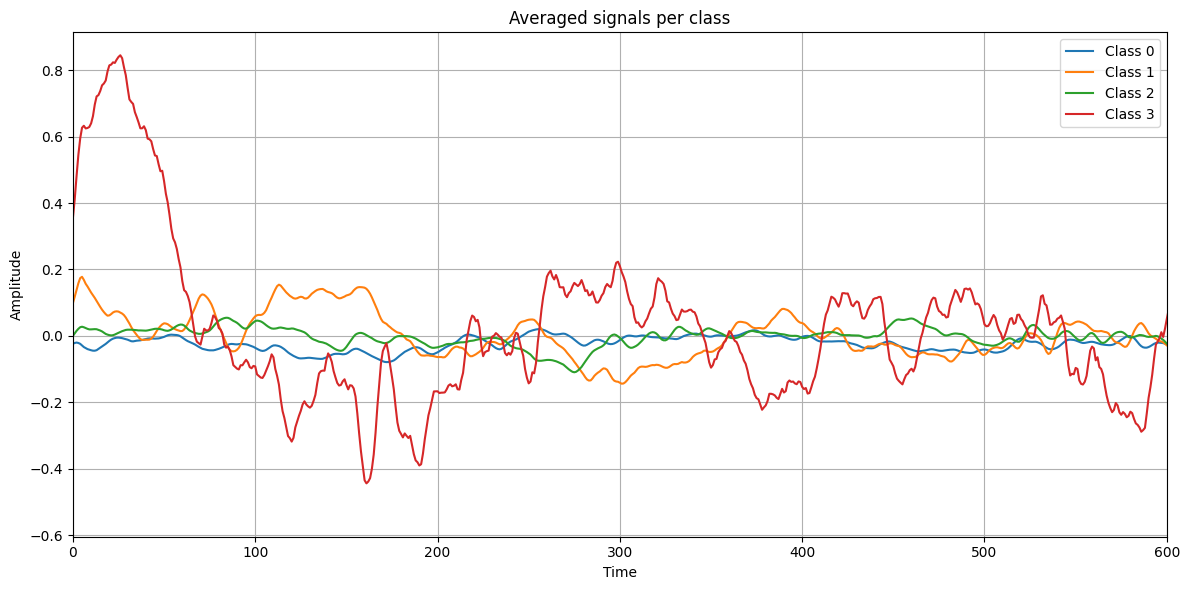

In [11]:
# plot mean distribution
max_lengths = 18286
df_norm = pd.DataFrame({"Data": normalized_data, "Class": df["Class"]})
df_norm["Data"] = df_norm["Data"].apply(lambda sample: np.pad(sample, (0, max_lengths - sample.shape[0])))
mean_signals = [np.mean(np.stack(df_norm[df_norm["Class"] == i]["Data"].to_numpy()), axis=0) for i in range(len(classes))]
plt.figure(figsize=(12, 6))

for mean_signal, clss in zip(mean_signals, classes):
    plt.plot(mean_signal, label=clss)

plt.title("Averaged signals per class")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, 600)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Create Training and Validation Split (80/20)

In [140]:
# create training and validation split
X_train, X_validation, y_train, y_validation = train_test_split(ecg_data, labels, test_size=0.3, random_state=0, stratify=labels)

# X_train = [np.array(x, dtype=np.float32) for x in X_train]
# X_validation = [np.array(x, dtype=np.float32) for x in X_validation]
train_lengths = [x.shape[0] for x in X_train]
validation_lengths = [x.shape[0] for x in X_validation]


# verify that the training and validation split is proportional to the original class distribution
counter0 = Counter(labels)
counter1 = Counter(y_train)
counter2 = Counter(y_validation)

total0 = len(labels)
ratios0 = np.array([counter0[0]/total0, counter0[1]/total0, counter0[2]/total0, counter0[3]/total0]) # original dataset ratios

total1 = counter1[0] + counter1[1] + counter1[2] + counter1[3]
ratios1 = np.array([counter1[0]/total1, counter1[1]/total1, counter1[2]/total1, counter1[3]/total1]) # training dataset ratios

total2 = counter2[0] + counter2[1] + counter2[2] + counter2[3]
ratios2 = np.array([counter2[0]/total2, counter2[1]/total2, counter2[2]/total2, counter2[3]/total2]) # validation dataset ratios

assert np.allclose(ratios0, ratios1, atol=1e-3)
assert np.allclose(ratios0, ratios2, atol=1e-3)
assert np.allclose(ratios1, ratios2, atol=1e-3)


# prepare data for training
# X_train, y_train = torch.tensor(zero_pad_data(X_train, max_val), dtype=torch.float32), torch.tensor(y_train)
# X_validation, y_validation = torch.tensor(zero_pad_data(X_validation, max_val), dtype=torch.float32), torch.tensor(y_validation)

# Task 1.2 - Modeling and Tuning

Define the actual model architecture

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(
            self, 
            channels: list[int], 
            kernel_sizes: list[int], 
            hidden_size: int, 
            num_layers: int,
            output_size: int,
            bidirectional: bool,  
            n_fft: int = 256, 
            hop_length: int = 128
    ):
        super(CNNLSTM, self).__init__()
        assert len(channels) == len(kernel_sizes)

        # input --> stft --> Conv2d --> BatchNorm2d --> ReLu --> MaxPool2d
        # define CNN model (Conv2d) to extract local patterns in sequences
        self.cnn = nn.Sequential()
        for idx in range(len(channels)):
            in_channels = 1 if idx == 0 else channels[idx - 1]
            out_channels = channels[idx]
            self.cnn.add_module(
                f"conv{idx}", 
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=kernel_sizes[idx], stride=1, padding=0
                )
            )
            self.cnn.add_module(f"bn{idx}", nn.BatchNorm2d(channels[idx]))
            self.cnn.add_module(f"relu{idx}", nn.ReLU())
            self.cnn.add_module(f"max_pool{idx}", nn.MaxPool2d(2))

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.len_num = 2 * len(channels)

        # define LSTM model to extract global patterns in sequences
        height = (n_fft // 2) + 1
        for kernel_size in kernel_sizes:
            height = math.floor(height - kernel_size) + 1 # conv-layer
            height = math.floor((height - 2) / 2) + 1 # maxpool-layer

        input_size = channels[-1] * height
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.5,
            bidirectional=bidirectional
        )
        directions = 2 if bidirectional else 1
        hidden_size *= directions
        self.fc = nn.Linear(hidden_size , output_size)
        # self.fc2 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        
        # feature extraction
        window = torch.hann_window(self.n_fft).to(x.device)
        x = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, window=window, return_complex=True).abs()

        # apply cnn model
        x = x.unsqueeze(dim=1)
        x = self.cnn(x) # output-shape: [64, 64, 62, 33] (batch_size, channels, freq_bins, time_bins)
        
        # re-calculate the updated lengths
        lengths = (lengths / self.hop_length).floor()
        lengths = lengths - self.len_num # conv-layer
        lengths = (lengths / self.len_num).floor() # maxpool-layer
        
        # prepare data for rnn
        x = x.view(x.size(0), -1, x.size(3))
        x = x.permute(0, 2, 1)
        lengths = lengths.clamp(min=1, max=x.size(1)).cpu().long()
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # apply lstm model
        _, (hn, cn) = self.rnn(x)
        if self.bidirectional:
            final_hn = torch.cat((hn[-2], hn[-1]), dim=1) # consider forward and backward direction
        else:
            final_hn = hn[-1]

        x = self.fc(final_hn)
        # x = self.fc2(x)
        return x


Define the training and test routine

In [142]:
def train(
        model: nn.Module, 
        device: torch.device, 
        train_loader: torch.utils.data.DataLoader, 
        criterion: nn.Module,
        optimizer: optim.Optimizer, 
        epoch: int
):
    model.train()
    for batch_idx, (data, target, lengths) in enumerate(train_loader):
        # forward pass
        data, target, lengths = data.to(device), target.to(device), lengths.to(device)
        optimizer.zero_grad()
        output = model(data, lengths)
        # backward pass
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            data_processed = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = (100. * batch_idx) / len(train_loader)
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed, total_data, progress, loss.item()
            ), end="\r")

def validate(
        model: nn.Module, 
        device: torch.device, 
        validation_loader: torch.utils.data.DataLoader,
        criterion: nn.Module
):
    model.eval()
    validation_loss = 0.
    correct = 0
    correct_per_class = torch.zeros(4)
    with torch.no_grad():
        for batch_idx, (data, target, lengths) in enumerate(validation_loader):
            # do forward pass
            data, target, lengths = data.to(device), target.to(device), lengths.to(device)
            output = model(data, lengths)
            validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            # compute correct predictions
            preds = output.argmax(dim=1, keepdim=False)
            mask = preds == target
            correct_preds = torch.count_nonzero(mask).item()
            correct += correct_preds
            for t, m in zip(target, mask):
                if m: correct_per_class[t] += 1

    total_data = len(validation_loader.dataset)
    validation_loss /= total_data
    progress = (100. * correct)  / len(validation_loader.dataset)
    
    print("Validation Set:\tAverage Loss {:.4f}\tAccuracy: {}/{} ({:.0f}%)\n".format(
        validation_loss, correct, total_data, progress
    ), end="\r")
    print("Class 0: {:.0f}/{}\tClass 1: {:.0f}/{}\tClass 3: {:.0f}/{}\tClass 3: {:.0f}/{}\n".format(
        correct_per_class[0], counter2[0], correct_per_class[1], counter2[1], correct_per_class[2], counter2[2], correct_per_class[3], counter2[3],
    ))
    
    return validation_loss

def evaluate_model(
        model: nn.Module,
        device: torch.device,
        test_loader: torch.utils.data.DataLoader,
        y_true: torch.Tensor,
        target_names: list
):
    model.eval()
    y_pred = torch.empty(0)
    
    with torch.no_grad():
        for data, _ in test_loader:
            # forward pass
            data = data.to(device)
            output = model(data)
            # compute correct predictions
            new_pred = output.argmax(dim=1, keepdim=False)
            y_pred = torch.cat((y_pred, new_pred))
    
    classification_report(y_true, y_pred, target_names=target_names)
    

In [143]:
num_samples_per_class = torch.from_numpy(df.groupby("Class").count()["Data"].to_numpy())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training of the model is running with: {device}")

# hyperparameters
num_epochs = 100
batch_size = 32
lr = 0.001
weight_decay = 0.0001

channels = [32, 64]
kernel_sizes = [3, 3]

hidden_size = 128
num_layers = 2
output_size = 4
bidirectional = True

n_fft = 256
hop_length = 128

# initialize model
model = CNNLSTM(
    channels, kernel_sizes, 
    hidden_size, num_layers, 
    output_size, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

weights =  num_samples_per_class.sum() / (num_samples_per_class * len(num_samples_per_class))
# criterion = nn.CrossEntropyLoss(weight=weights.float().to(device))
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) # try lr: 0.01 or 0.001 and other weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5)

training_data = TimeSeriesDataset(X_train, y_train, train_lengths)
validation_data = TimeSeriesDataset(X_validation, y_validation, validation_lengths)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_data, batch_size=batch_size, collate_fn=collate_fn)

# training and test loop
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss = validate(model, device, validation_loader, criterion)
    scheduler.step(valid_loss)
    
evaluate_model(model, device, validation_loader, y_validation, classes)

Training of the model is running with: cuda
Validation Set:	Average Loss 0.9479	Accuracy: 1133/1854 (61%)
Class 0: 939/1091	Class 1: 92/165	Class 3: 63/530	Class 3: 39/68

Validation Set:	Average Loss 1.3035	Accuracy: 657/1854 (35%)
Class 0: 315/1091	Class 1: 134/165	Class 3: 153/530	Class 3: 55/68

Validation Set:	Average Loss 0.8384	Accuracy: 1173/1854 (63%)
Class 0: 987/1091	Class 1: 80/165	Class 3: 42/530	Class 3: 64/68

Validation Set:	Average Loss 0.8231	Accuracy: 1216/1854 (66%)
Class 0: 862/1091	Class 1: 110/165	Class 3: 181/530	Class 3: 63/68

Validation Set:	Average Loss 0.8097	Accuracy: 1212/1854 (65%)
Class 0: 820/1091	Class 1: 112/165	Class 3: 221/530	Class 3: 59/68

Validation Set:	Average Loss 0.7476	Accuracy: 1290/1854 (70%)
Class 0: 980/1091	Class 1: 112/165	Class 3: 133/530	Class 3: 65/68

Validation Set:	Average Loss 0.8019	Accuracy: 1299/1854 (70%)
Class 0: 856/1091	Class 1: 104/165	Class 3: 276/530	Class 3: 63/68

Validation Set:	Average Loss 0.7429	Accuracy: 1267/

KeyboardInterrupt: 

In [ ]:
'''
-- mit log2
Validation Set: Average Loss 1.2355, Accuracy: 660/1236 (53%)
Validation Set: Average Loss 1.2226, Accuracy: 280/1236 (23%)
Validation Set: Average Loss 1.1676, Accuracy: 222/1236 (18%)
Validation Set: Average Loss 1.2645, Accuracy: 150/1236 (12%)
Validation Set: Average Loss 1.2164, Accuracy: 255/1236 (21%)
Validation Set: Average Loss 1.1568, Accuracy: 392/1236 (32%)
Validation Set: Average Loss 1.1648, Accuracy: 411/1236 (33%)
Validation Set: Average Loss 1.1716, Accuracy: 292/1236 (24%)

-- ohne log2
Validation Set: Average Loss 1.1630, Accuracy: 626/1236 (51%)
Validation Set: Average Loss 1.1218, Accuracy: 411/1236 (33%)
Validation Set: Average Loss 1.1386, Accuracy: 362/1236 (29%)
Validation Set: Average Loss 1.0890, Accuracy: 675/1236 (55%)
Validation Set: Average Loss 1.1030, Accuracy: 527/1236 (43%)
Validation Set: Average Loss 1.1014, Accuracy: 662/1236 (54%)
Validation Set: Average Loss 1.0843, Accuracy: 528/1236 (43%)
Validation Set: Average Loss 1.0490, Accuracy: 697/1236 (56%)


-- mit min max scaler
Validation Set: Average Loss 1.3694, Accuracy: 695/1236 (56%)
Validation Set: Average Loss 1.3279, Accuracy: 699/1236 (57%)
Validation Set: Average Loss 1.2265, Accuracy: 583/1236 (47%)
Validation Set: Average Loss 1.1812, Accuracy: 241/1236 (19%)
Validation Set: Average Loss 1.1525, Accuracy: 258/1236 (21%)
Validation Set: Average Loss 1.1157, Accuracy: 339/1236 (27%)
Validation Set: Average Loss 1.0987, Accuracy: 408/1236 (33%)

-- ohne min max scaler
Validation Set: Average Loss 1.3544, Accuracy: 273/1236 (22%)
Validation Set: Average Loss 1.3171, Accuracy: 334/1236 (27%)
Validation Set: Average Loss 1.2616, Accuracy: 354/1236 (29%)
Validation Set: Average Loss 1.2030, Accuracy: 344/1236 (28%)
Validation Set: Average Loss 1.1772, Accuracy: 406/1236 (33%)
Validation Set: Average Loss 1.1630, Accuracy: 471/1236 (38%)
Validation Set: Average Loss 1.1514, Accuracy: 601/1236 (49%)
Validation Set: Average Loss 1.1464, Accuracy: 469/1236 (38%)
Validation Set: Average Loss 1.1340, Accuracy: 594/1236 (48%)
Validation Set: Average Loss 1.1242, Accuracy: 637/1236 (52%)
Validation Set: Average Loss 1.1233, Accuracy: 629/1236 (51%)
Validation Set: Average Loss 1.1218, Accuracy: 635/1236 (51%)
Validation Set: Average Loss 1.1187, Accuracy: 636/1236 (51%)
Validation Set: Average Loss 1.1180, Accuracy: 639/1236 (52%)
Validation Set: Average Loss 1.1161, Accuracy: 649/1236 (53%)
Validation Set: Average Loss 1.1168, Accuracy: 648/1236 (52%)
Validation Set: Average Loss 1.1173, Accuracy: 647/1236 (52%)
Validation Set: Average Loss 1.1156, Accuracy: 633/1236 (51%)
Validation Set: Average Loss 1.1143, Accuracy: 635/1236 (51%)
Validation Set: Average Loss 1.1137, Accuracy: 634/1236 (51%)


-------------------------------------------
num_epochs = 20
batch_size = 64
lr = 0.001
weight_decay = 0.0001
step_size = 10
gamma = 0.1

input_size = 257
hidden_size = 64
num_layers = 2
output_size = 4

Validation Set: Average Loss 1.0932, Accuracy: 640/1236 (52%)
Validation Set: Average Loss 1.0989, Accuracy: 624/1236 (50%)
Validation Set: Average Loss 1.0565, Accuracy: 671/1236 (54%)
Validation Set: Average Loss 1.0006, Accuracy: 595/1236 (48%)
Validation Set: Average Loss 0.9564, Accuracy: 638/1236 (52%)
Validation Set: Average Loss 0.9267, Accuracy: 671/1236 (54%)
Validation Set: Average Loss 1.0927, Accuracy: 783/1236 (63%)
Validation Set: Average Loss 0.9567, Accuracy: 707/1236 (57%)
Validation Set: Average Loss 0.9516, Accuracy: 733/1236 (59%)
Validation Set: Average Loss 1.0527, Accuracy: 774/1236 (63%)
Validation Set: Average Loss 0.9122, Accuracy: 789/1236 (64%)
Validation Set: Average Loss 0.9102, Accuracy: 770/1236 (62%)
Validation Set: Average Loss 0.9324, Accuracy: 778/1236 (63%)
Validation Set: Average Loss 0.9331, Accuracy: 779/1236 (63%)
Validation Set: Average Loss 0.9604, Accuracy: 816/1236 (66%)
Validation Set: Average Loss 0.9579, Accuracy: 813/1236 (66%)
Validation Set: Average Loss 0.9555, Accuracy: 803/1236 (65%)
Validation Set: Average Loss 0.9394, Accuracy: 786/1236 (64%)
Validation Set: Average Loss 0.9620, Accuracy: 800/1236 (65%)
Validation Set: Average Loss 0.9476, Accuracy: 797/1236 (64%)


-- bisher beste mit 78% accuracy

weights =  num_samples_per_class.max() / num_samples_per_class
num_epochs = 20
batch_size = 64
lr = 0.001
weight_decay = 0.0001
step_size = 10
gamma = 0.1

input_size = 129
hidden_size = 128
num_layers = 2
output_size = 4




-------------------------------------------------------

# hyperparameters
num_epochs = 60
batch_size = 32
lr = 0.001
weight_decay = 0.0001

channels = [32, 64]
kernel_sizes = [3, 3]

hidden_size = 128
num_layers = 2
output_size = 4

n_fft = 256
hop_length = 128




Training of the model is running with: cuda
Validation Set:	Average Loss 1.0358	Accuracy: 742/1236 (60%)
Class 0: 618/728	Class 1: 61/110	Class 3: 36/353	Class 3: 27/45

Validation Set:	Average Loss 0.8886	Accuracy: 739/1236 (60%)
Class 0: 538/728	Class 1: 65/110	Class 3: 91/353	Class 3: 45/45

Validation Set:	Average Loss 0.8290	Accuracy: 772/1236 (62%)
Class 0: 580/728	Class 1: 79/110	Class 3: 71/353	Class 3: 42/45

Validation Set:	Average Loss 0.8111	Accuracy: 757/1236 (61%)
Class 0: 563/728	Class 1: 85/110	Class 3: 67/353	Class 3: 42/45

Validation Set:	Average Loss 0.8874	Accuracy: 684/1236 (55%)
Class 0: 450/728	Class 1: 89/110	Class 3: 101/353	Class 3: 44/45

Validation Set:	Average Loss 0.8580	Accuracy: 837/1236 (68%)
Class 0: 658/728	Class 1: 54/110	Class 3: 80/353	Class 3: 45/45

Validation Set:	Average Loss 0.8531	Accuracy: 775/1236 (63%)
Class 0: 504/728	Class 1: 87/110	Class 3: 149/353	Class 3: 35/45

Validation Set:	Average Loss 0.8871	Accuracy: 878/1236 (71%)
Class 0: 704/728	Class 1: 59/110	Class 3: 78/353	Class 3: 37/45

Validation Set:	Average Loss 0.6702	Accuracy: 865/1236 (70%)
Class 0: 561/728	Class 1: 82/110	Class 3: 183/353	Class 3: 39/45

Validation Set:	Average Loss 0.6811	Accuracy: 807/1236 (65%)
Class 0: 561/728	Class 1: 96/110	Class 3: 111/353	Class 3: 39/45

Validation Set:	Average Loss 0.7332	Accuracy: 797/1236 (64%)
Class 0: 475/728	Class 1: 92/110	Class 3: 189/353	Class 3: 41/45

Validation Set:	Average Loss 0.6550	Accuracy: 907/1236 (73%)
Class 0: 611/728	Class 1: 88/110	Class 3: 166/353	Class 3: 42/45

Validation Set:	Average Loss 0.6516	Accuracy: 873/1236 (71%)
Class 0: 616/728	Class 1: 97/110	Class 3: 121/353	Class 3: 39/45

Validation Set:	Average Loss 0.7664	Accuracy: 861/1236 (70%)
Class 0: 507/728	Class 1: 86/110	Class 3: 236/353	Class 3: 32/45

Validation Set:	Average Loss 0.6505	Accuracy: 962/1236 (78%)
Class 0: 626/728	Class 1: 81/110	Class 3: 216/353	Class 3: 39/45

Validation Set:	Average Loss 0.6249	Accuracy: 920/1236 (74%)
Class 0: 565/728	Class 1: 86/110	Class 3: 228/353	Class 3: 41/45

Validation Set:	Average Loss 0.6520	Accuracy: 962/1236 (78%)
Class 0: 614/728	Class 1: 80/110	Class 3: 228/353	Class 3: 40/45

Validation Set:	Average Loss 0.6145	Accuracy: 904/1236 (73%)
Class 0: 569/728	Class 1: 91/110	Class 3: 204/353	Class 3: 40/45

Validation Set:	Average Loss 0.6215	Accuracy: 930/1236 (75%)
Class 0: 605/728	Class 1: 102/110	Class 3: 184/353	Class 3: 39/45

Validation Set:	Average Loss 0.7268	Accuracy: 787/1236 (64%)
Class 0: 458/728	Class 1: 104/110	Class 3: 185/353	Class 3: 40/45

Validation Set:	Average Loss 0.6143	Accuracy: 975/1236 (79%)
Class 0: 628/728	Class 1: 78/110	Class 3: 226/353	Class 3: 43/45

Validation Set:	Average Loss 0.6613	Accuracy: 958/1236 (78%)
Class 0: 579/728	Class 1: 89/110	Class 3: 254/353	Class 3: 36/45

Validation Set:	Average Loss 0.6885	Accuracy: 960/1236 (78%)
Class 0: 629/728	Class 1: 97/110	Class 3: 198/353	Class 3: 36/45

Validation Set:	Average Loss 0.7042	Accuracy: 998/1236 (81%)
Class 0: 649/728	Class 1: 88/110	Class 3: 228/353	Class 3: 33/45

Validation Set:	Average Loss 0.7118	Accuracy: 999/1236 (81%)
Class 0: 640/728	Class 1: 89/110	Class 3: 239/353	Class 3: 31/45

Validation Set:	Average Loss 0.6622	Accuracy: 1005/1236 (81%)
Class 0: 652/728	Class 1: 78/110	Class 3: 237/353	Class 3: 38/45

Validation Set:	Average Loss 0.6847	Accuracy: 990/1236 (80%)
Class 0: 625/728	Class 1: 82/110	Class 3: 248/353	Class 3: 35/45

Validation Set:	Average Loss 0.7179	Accuracy: 982/1236 (79%)
Class 0: 609/728	Class 1: 86/110	Class 3: 254/353	Class 3: 33/45

Validation Set:	Average Loss 0.7509	Accuracy: 989/1236 (80%)
Class 0: 612/728	Class 1: 81/110	Class 3: 264/353	Class 3: 32/45

Validation Set:	Average Loss 0.7549	Accuracy: 990/1236 (80%)
Class 0: 608/728	Class 1: 81/110	Class 3: 269/353	Class 3: 32/45

Validation Set:	Average Loss 0.7736	Accuracy: 993/1236 (80%)
Class 0: 623/728	Class 1: 83/110	Class 3: 256/353	Class 3: 31/45

Validation Set:	Average Loss 0.7598	Accuracy: 988/1236 (80%)
Class 0: 613/728	Class 1: 83/110	Class 3: 260/353	Class 3: 32/45

Validation Set:	Average Loss 0.8184	Accuracy: 1008/1236 (82%)
Class 0: 636/728	Class 1: 79/110	Class 3: 261/353	Class 3: 32/45

Validation Set:	Average Loss 0.8195	Accuracy: 993/1236 (80%)
Class 0: 620/728	Class 1: 79/110	Class 3: 263/353	Class 3: 31/45

Validation Set:	Average Loss 0.8285	Accuracy: 1006/1236 (81%)
Class 0: 629/728	Class 1: 81/110	Class 3: 264/353	Class 3: 32/45

Validation Set:	Average Loss 0.8150	Accuracy: 993/1236 (80%)
Class 0: 618/728	Class 1: 80/110	Class 3: 264/353	Class 3: 31/45

Validation Set:	Average Loss 0.7840	Accuracy: 993/1236 (80%)
Class 0: 611/728	Class 1: 82/110	Class 3: 268/353	Class 3: 32/45

Validation Set:	Average Loss 0.8158	Accuracy: 998/1236 (81%)
Class 0: 616/728	Class 1: 80/110	Class 3: 270/353	Class 3: 32/45

Validation Set:	Average Loss 0.8061	Accuracy: 993/1236 (80%)
Class 0: 616/728	Class 1: 80/110	Class 3: 266/353	Class 3: 31/45

Validation Set:	Average Loss 0.8029	Accuracy: 995/1236 (81%)
Class 0: 621/728	Class 1: 82/110	Class 3: 261/353	Class 3: 31/45

Validation Set:	Average Loss 0.7946	Accuracy: 994/1236 (80%)
Class 0: 615/728	Class 1: 82/110	Class 3: 265/353	Class 3: 32/45

Validation Set:	Average Loss 0.8113	Accuracy: 996/1236 (81%)
Class 0: 616/728	Class 1: 82/110	Class 3: 266/353	Class 3: 32/45

Train Epoch: 43 [2880/4943 (58%)]	Loss: 0.166655
'''

'\n-- mit log2\nValidation Set: Average Loss 1.2355, Accuracy: 660/1236 (53%)\nValidation Set: Average Loss 1.2226, Accuracy: 280/1236 (23%)\nValidation Set: Average Loss 1.1676, Accuracy: 222/1236 (18%)\nValidation Set: Average Loss 1.2645, Accuracy: 150/1236 (12%)\nValidation Set: Average Loss 1.2164, Accuracy: 255/1236 (21%)\nValidation Set: Average Loss 1.1568, Accuracy: 392/1236 (32%)\nValidation Set: Average Loss 1.1648, Accuracy: 411/1236 (33%)\nValidation Set: Average Loss 1.1716, Accuracy: 292/1236 (24%)\n\n-- ohne log2\nValidation Set: Average Loss 1.1630, Accuracy: 626/1236 (51%)\nValidation Set: Average Loss 1.1218, Accuracy: 411/1236 (33%)\nValidation Set: Average Loss 1.1386, Accuracy: 362/1236 (29%)\nValidation Set: Average Loss 1.0890, Accuracy: 675/1236 (55%)\nValidation Set: Average Loss 1.1030, Accuracy: 527/1236 (43%)\nValidation Set: Average Loss 1.1014, Accuracy: 662/1236 (54%)\nValidation Set: Average Loss 1.0843, Accuracy: 528/1236 (43%)\nValidation Set: Average